In [1]:
from cpc_pipeline import *
import random

from llm import LLM
gpt35t = LLM("gpt-3.5-turbo")
gpt4 = LLM("gpt-4")

### TEMP: Experimenting with CPC variations

In [2]:
from make_quadratic_problems import make_quadratic_problem
problem_df = cpc_problems(make_quadratic_problem, {'max': range(5, 50, 5), 'factorable': [True, False]}, n=5)

Reading cpc_pipeline/make_quadratic_problem928671622.csv...


In [3]:
# prompt validated by switching analysis earlier
prompt = "Please find the roots of the quadratic equation {equation}. Start by trying to factor the equation. If you can't factor it, then use the quadratic formula. If you factor the equation successfully, do not use the quadratic formula." # removed instruction to say SWITCHING. swapped out for an alternative to enforce factoring first
# remember to force feed the model so it starts by attempting factoring! Otherwise switching will be too low.
false_start = "First, I'll try solving this equation by factoring."

def completion_35t(eq):
    try:
        return gpt35t.chat_completion_false_start(prompt.format(equation=eq), false_start=false_start)
    except Exception as e:
        print(f"Error while processing {eq}: {type(e)} {e}")
        return f"Exception: {type(e)} {e}"
    
def completion_4(eq):
    try:
        return gpt4.chat_completion_false_start(prompt.format(equation=eq), false_start=false_start)
    except Exception as e:
        print(f"Error while processing {eq}: {type(e)} {e}")
        return {'equation': eq, 'context': f"Exception: {type(e)} {e}"}
    
context_df_35t = cpc_contexts(problem_df, completion_35t)
context_df_4 = cpc_contexts(problem_df, completion_4)
assert not any(context_df_35t['context'].str.contains('Exception'))
assert not any(context_df_4['context'].str.contains('Exception'))

Reading cpc_pipeline/completion_35t2797116717.csv...
Reading cpc_pipeline/completion_42523948259.csv...


In [4]:
from new_switch_utils import make_non_decreasing, original_4

def split_and_judge_row_gpt4(context, chunk_size):
    prefixes = [context[:pref_end] for pref_end in list(range(chunk_size, len(context), chunk_size))]+[context]
    measured_switching = [original_4(context, prefix) for prefix in prefixes]
    processed_switching = random.choice(make_non_decreasing(measured_switching))
    return prefixes, processed_switching

switching_df_35t = split_and_judge_switching(context_df_35t, split_and_judge_row_gpt4, 50)
switching_df_4 = split_and_judge_switching(context_df_4, split_and_judge_row_gpt4, 50)

Reading cpc_pipeline/split_and_judge_row_gpt44184359523.csv...
Reading cpc_pipeline/split_and_judge_row_gpt4968971211.csv...


In [5]:
from solver import perform_one_token_cpc, perform_cot_cpc
def gpt35t_1t(context):
    return perform_one_token_cpc(gpt35t, context)
def gpt35t_cot(context):
    return perform_cot_cpc(gpt35t, context)
def gpt4_1t(context):
    return perform_one_token_cpc(gpt4, context)
def gpt4_cot(context):
    return perform_cot_cpc(gpt4, context)

cpc_df_35t = judge_cpc(switching_df_35t, [gpt35t_1t, gpt35t_cot])
cpc_df_4 = judge_cpc(switching_df_4, [gpt4_1t, gpt4_cot])

Creating cpc_pipeline/cpc_3784578608.csv...
Creating cpc_pipeline/cpc_2857944803.csv...


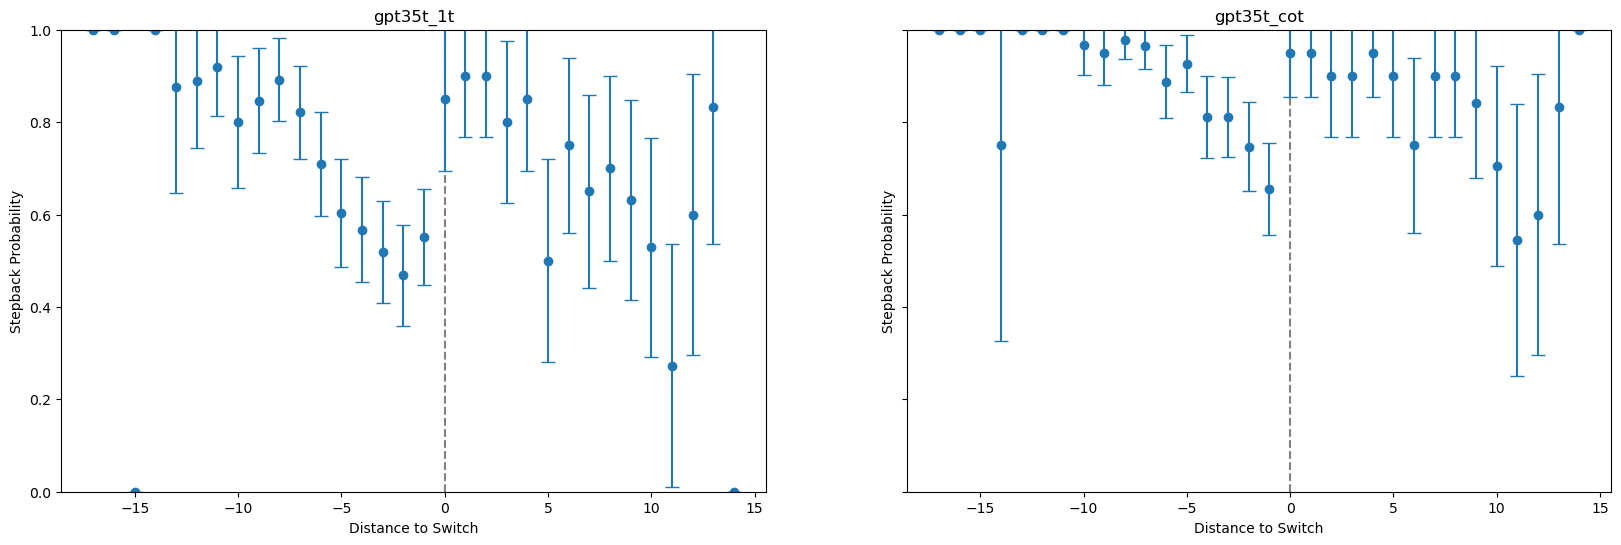

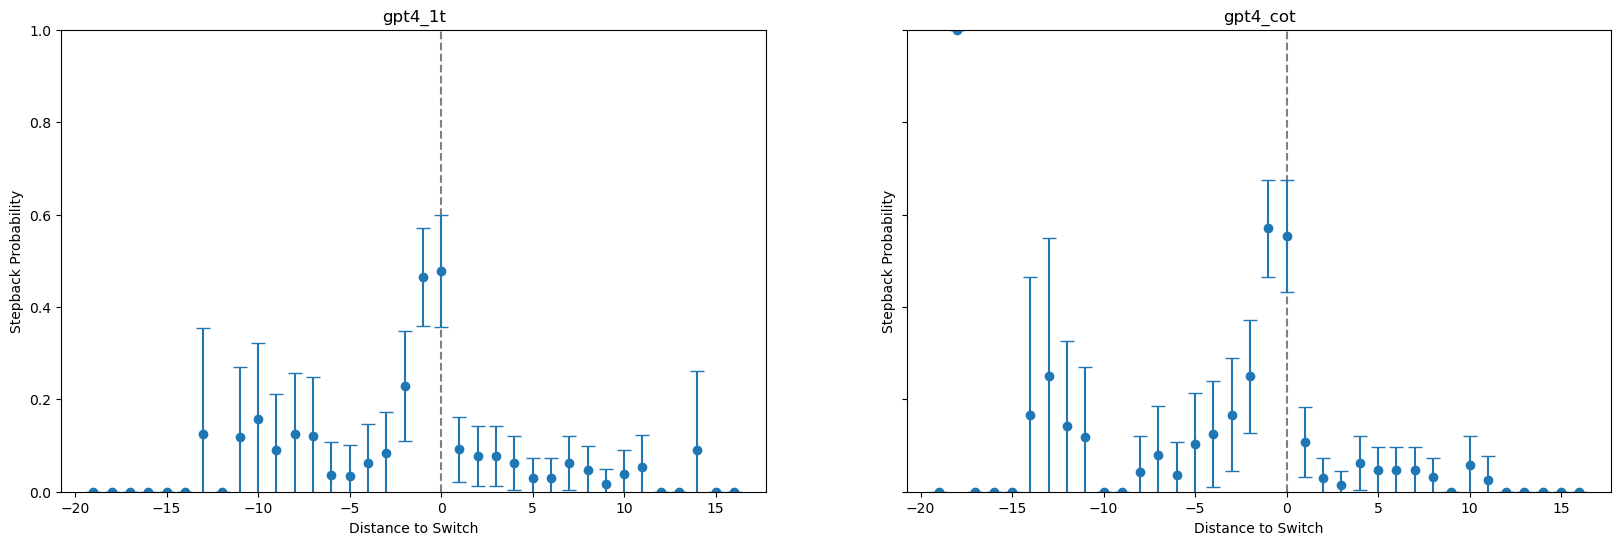

In [6]:
do_analysis(cpc_df_35t, [gpt35t_1t, gpt35t_cot])
do_analysis(cpc_df_4, [gpt4_1t, gpt4_cot])

In [7]:
sum(cpc_df_35t['gpt35t_cot'] == cpc_df_35t['gpt35t_1t'])/len(cpc_df_35t), sum(cpc_df_4['gpt4_cot'] == cpc_df_4['gpt4_1t'])/len(cpc_df_4)

(0.6825568797399784, 0.915268456375839)

(array([539., 242.,  81.,  43.,  43.,  53.,  98.,  57.,  17.,  19.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

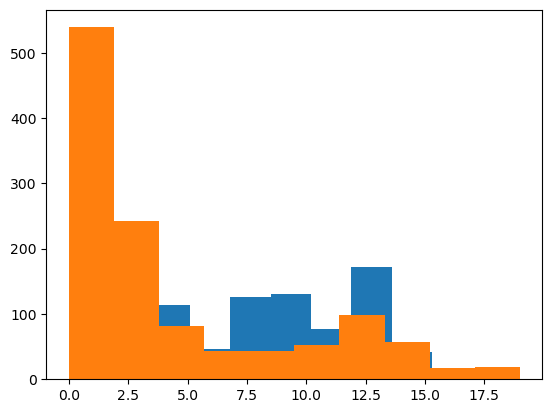

In [8]:
plt.hist(cpc_df_35t['switch_index'])
plt.hist(cpc_df_4['switch_index'])